# Data Set Summary Info

This notebook provides summary information and descriptive statistics for our data sets.

## Setup

In [1]:
import sys
import re

In [2]:
from pathlib import Path

In [3]:
import itertools as it
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import plotnine as p

In [4]:
import bookgender.datatools as dt
from bookgender.nbutils import *

In [5]:
def eprint(*args):
    print(*args, file=sys.stderr)

In [6]:
fig_dir = init_figs('DataSummary')

using figure dir figures\DataSummary


In [7]:
def lbl_pct(fs):
    return ['{:.0f}%'.format(f*100) for f in fs]

Function to make plots:

## Load Data Files

Load book author gender info:

In [8]:
datasets =  sorted(list(dt.datasets.keys()))

In [9]:
book_gender = pd.read_parquet('data/author-gender.parquet')
book_gender['gender'] = book_gender['gender'].astype('category')
book_gender.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12234574 entries, 0 to 12234573
Data columns (total 2 columns):
 #   Column  Dtype   
---  ------  -----   
 0   item    int64   
 1   gender  category
dtypes: category(1), int64(1)
memory usage: 105.0 MB


In [10]:
book_gender = pd.read_csv('data/author-gender.csv.gz', dtype={'gender': 'category'})
book_gender.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12234574 entries, 0 to 12234573
Data columns (total 2 columns):
 #   Column  Dtype   
---  ------  -----   
 0   item    int64   
 1   gender  category
dtypes: category(1), int64(1)
memory usage: 105.0 MB


Book gender will be more useful if we index it, and it's basically now a series.

In [11]:
book_gender = book_gender.set_index('item')['gender']
book_gender

item
0                     male
1           no-viaf-author
2                     male
3            no-loc-author
4                     male
                 ...      
12234569     no-loc-author
12234570     no-loc-author
12234571     no-loc-author
12234572     no-loc-author
12234573     no-loc-author
Name: gender, Length: 12234574, dtype: category
Categories (6, object): ['ambiguous', 'female', 'male', 'no-loc-author', 'no-viaf-author', 'unknown']

Load the Library of Congress book list:

In [12]:
loc_books = pd.read_csv('data/loc-books.csv.gz')
loc_books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5267327 entries, 0 to 5267326
Data columns (total 1 columns):
 #   Column  Dtype
---  ------  -----
 0   item    int64
dtypes: int64(1)
memory usage: 40.2 MB


Load rating data sets:

In [13]:
ratings = {}
for ds in datasets:
    eprint('loading ratings for', ds)
    ratings[ds] = pd.read_parquet(f'data/{ds}/ratings.parquet')

loading ratings for AZ
loading ratings for BX-E
loading ratings for BX-I
loading ratings for GR-E
loading ratings for GR-I


### Fill and Expand Gender

For later computations, we want to upgrade the book-gender frame so it has the following properties:

* All available books have a gender record
* Both full status and simplified unlink status are available for each book

This will simplify combining other records with the book gender data later.

Let's start by making a huge array of all available book IDs:

In [14]:
item_lists = [loc_books['item'].unique()]
for rdf in ratings.values():
    item_lists.append(rdf['item'].unique())
all_item_ids = np.unique(np.concatenate(item_lists))
all_item_ids.shape

(7387475,)

How does that compare to the book gender frame?

In [15]:
book_gender.count()

12234574

Add a category to `gender` for no-matching-book, and put an order on the categories (we're also going to make `book_gender` refer to the series, to simplify code):

In [16]:
book_gender.cat.add_categories(['no-book'], inplace=True)
book_gender.cat.reorder_categories(['no-book', 'no-loc-author', 'no-viaf-author',
                                    'unknown', 'ambiguous', 'female', 'male'],
                                   inplace=True)

Reindex to match our list of book IDs, and fill in the missing value:

In [17]:
book_gender = book_gender.reindex(all_item_ids, fill_value='no-book')
book_gender

item
0                      male
1            no-viaf-author
2                      male
3             no-loc-author
4                      male
                  ...      
924482338           no-book
924482339           no-book
924482340           no-book
924482341           no-book
924482342           no-book
Name: gender, Length: 7387475, dtype: category
Categories (7, object): ['no-book', 'no-loc-author', 'no-viaf-author', 'unknown', 'ambiguous', 'female', 'male']

Now the index should be both monotonic and unique - this should simplify later use. Double-check:

In [18]:
book_gender.index.is_unique

True

In [19]:
book_gender.index.is_monotonic

True

Let's quick look at a histogram:

<AxesSubplot:xlabel='gender', ylabel='count'>

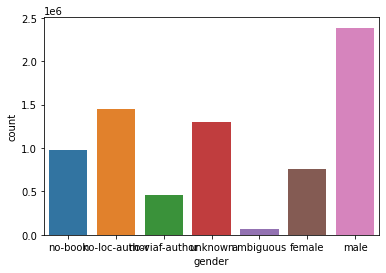

In [20]:
sns.countplot(book_gender)

Ok. Last thing we need to do here is create a simplified column that collapsed our various types of link failure into 'unlinked'.  We'll put this in the `gender` column, and make the existing series `gender_status`:

In [21]:
book_gender = pd.DataFrame({
    'gender_status': book_gender,
    'gender': book_gender.cat.rename_categories({
        'no-book': 'unlinked'
    }).cat.remove_categories([
        'no-loc-author', 'no-viaf-author'
    ]).fillna('unlinked')
})
book_gender

,gender_status,gender
item,,
0,male,male
1,no-viaf-author,unlinked
2,male,male
3,no-loc-author,unlinked
4,male,male
...,...,...
924482338,no-book,unlinked
924482339,no-book,unlinked
924482340,no-book,unlinked


And see that histogram:

<AxesSubplot:xlabel='gender', ylabel='count'>

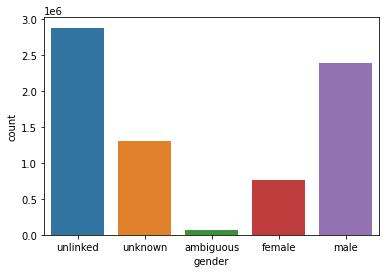

In [22]:
sns.countplot(book_gender['gender'])

## Basic Data Set Stats

In [23]:
ds_summary = pd.DataFrame.from_dict(dict(
    (n, {'Users': f['user'].nunique(), 'Items': f['item'].nunique(), 'Pairs': len(f)})
    for (n, f) in ratings.items()
), orient='index')
ds_summary['Density'] = ds_summary['Pairs'] / (ds_summary['Users'] * ds_summary['Items'])
ds_summary

,Users,Items,Pairs,Density
AZ,8026324,2268142,22460535,0.000001
BX-E,77805,151670,427283,0.000036
BX-I,105283,279501,1129814,0.000038
GR-E,808782,1080777,86537566,0.000099
GR-I,870011,1096636,188943278,0.000198


In [24]:
def pct_fmt(p):
    return '{:.4f}%'.format(p * 100)
def n_fmt(n):
    return '{:,d}'.format(n)
print(ds_summary.to_latex(formatters={
    'Users': n_fmt,
    'Items': n_fmt,
    'Pairs': n_fmt,
    'Density': pct_fmt
}))

\begin{tabular}{lrrrr}
\toprule
{} &     Users &     Items &       Pairs & Density \\
\midrule
AZ   & 8,026,324 & 2,268,142 &  22,460,535 & 0.0001\% \\
BX-E &    77,805 &   151,670 &     427,283 & 0.0036\% \\
BX-I &   105,283 &   279,501 &   1,129,814 & 0.0038\% \\
GR-E &   808,782 & 1,080,777 &  86,537,566 & 0.0099\% \\
GR-I &   870,011 & 1,096,636 & 188,943,278 & 0.0198\% \\
\bottomrule
\end{tabular}



### Distributions

What is the rating distribution for explicit-feedback data sets?

In [25]:
exp_re = re.compile(r'^\w\w(-E|$)')
[ds for ds in ratings.keys() if exp_re.match(ds)]

['AZ', 'BX-E', 'GR-E']

In [26]:
exp_rate_stats = pd.concat(
    (rates.groupby('rating').item.count().reset_index(name='count').assign(Set=ds)
     for (ds, rates) in ratings.items() if exp_re.match(ds))
, ignore_index=True)
exp_rate_stats.head()

,rating,count,Set
0,1.0,1115069,AZ
1,1.5,254,AZ
2,2.0,976839,AZ
3,2.5,453,AZ
4,3.0,1918050,AZ


C:\Users\michaelekstrand\Anaconda3\envs\bookfair\lib\site-packages\seaborn\axisgrid.py:723: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.


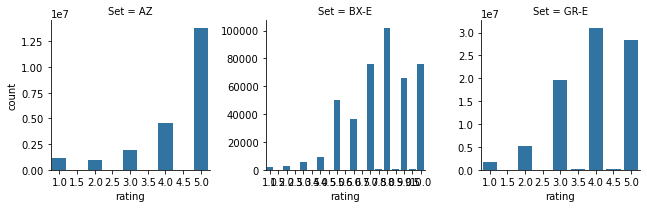

In [27]:
grid = sns.FacetGrid(col='Set', data=exp_rate_stats, sharex=False, sharey=False)
grid.map(sns.barplot, 'rating', 'count')

In [28]:
user_means = pd.concat(
    (rates.groupby('user').rating.mean().reset_index(name='AvgRating').assign(Set=ds)
     for (ds, rates) in ratings.items() if exp_re.match(ds))
, ignore_index=True)
user_means.head()

,user,AvgRating,Set
0,1,5.000000,AZ
1,2,5.000000,AZ
2,3,5.000000,AZ
3,4,4.666667,AZ
4,5,4.000000,AZ


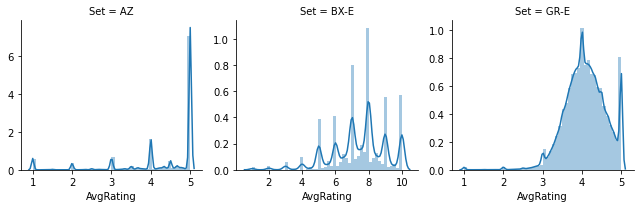

In [29]:
grid = sns.FacetGrid(col='Set', data=user_means, sharey=False, sharex=False)
grid.map(sns.distplot, 'AvgRating')

In [30]:
item_means = pd.concat(
    (rates.groupby('item').rating.mean().reset_index(name='AvgRating').assign(Set=ds)
     for (ds, rates) in ratings.items() if exp_re.match(ds))
, ignore_index=True)
item_means.head()

,item,AvgRating,Set
0,0,4.250000,AZ
1,2,4.523077,AZ
2,5,4.348315,AZ
3,8,4.368421,AZ
4,11,3.968750,AZ


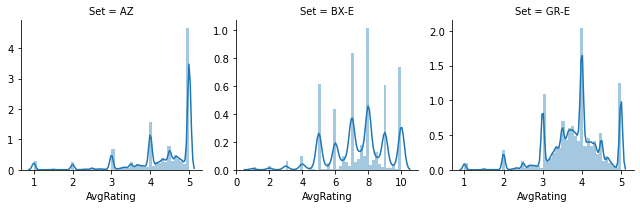

In [31]:
grid = sns.FacetGrid(col='Set', data=item_means, sharey=False, sharex=False)
grid.map(sns.distplot, 'AvgRating')

## Count and Integrate

Now that we have the data loaded, we need to do a few things:

1. Connect with gender info
2. Count books (or ratings) by gender. All kinds of unlinked gender are mapped to `unlinked`.
3. Integrate into a single set of lists

To start, we'll define a helper function for summarizing a frame of interactions by gender:

In [32]:
def summarize_by_gender(rate_frame, gender_col='gender'):
    # count ratings per book
    i_counts = rate_frame['item'].value_counts().to_frame(name='ratings')
    # join with gender
    books = i_counts.join(book_gender)
    # count by gender
    counts = books.groupby(gender_col)['ratings'].agg(['count', 'sum'])
    counts.rename(columns={
        'count': 'Books',
        'sum': 'Ratings'
    }, inplace=True)
    return counts

Let's see the function in action:

In [33]:
summarize_by_gender(ratings['BX-E'])

,Books,Ratings
gender,,
unlinked,36757,45524
unknown,16900,27434
ambiguous,4014,30444
female,38093,138827
male,55906,185054


Now build up a full frame of everything:

In [34]:
eprint('summarizing LOC')
summaries = {'LOC':  summarize_by_gender(loc_books).assign(ratings=np.nan) }
for ds, f in ratings.items():
    eprint('summarizing', ds)
    summaries[ds] = summarize_by_gender(f)
gender_stats = pd.concat(summaries, names=['DataSet'])
gender_stats.info()

summarizing LOC
summarizing AZ
summarizing BX-E
summarizing BX-I
summarizing GR-E
summarizing GR-I


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 30 entries, ('LOC', 'unlinked') to ('GR-I', 'male')
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Books    30 non-null     int64  
 1   Ratings  30 non-null     int64  
 2   ratings  0 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 1.3+ KB


In [35]:
eprint('summarizing LOC')
fsums = {'LOC': summarize_by_gender(loc_books, 'gender_status')}
for ds, f in ratings.items():
    eprint('summarizing', ds)
    fsums[ds] = summarize_by_gender(f, 'gender_status')
full_stats = pd.concat(fsums, names=['DataSet'])
full_stats.info()

summarizing LOC
summarizing AZ
summarizing BX-E
summarizing BX-I
summarizing GR-E
summarizing GR-I


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 42 entries, ('LOC', 'no-book') to ('GR-I', 'male')
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   Books    42 non-null     int64
 1   Ratings  42 non-null     int64
dtypes: int64(2)
memory usage: 1.4+ KB


In [36]:
book_counts = full_stats['Books'].unstack()
book_counts

gender_status,no-book,no-loc-author,no-viaf-author,unknown,ambiguous,female,male
DataSet,,,,,,,
LOC,0,842755,297405,1214597,53232,664221,2195117
AZ,934847,226764,157072,236219,17056,215556,480628
BX-E,22674,6456,7627,16900,4014,38093,55906
BX-I,45560,12906,15631,34614,6770,67087,96933
GR-E,0,487495,35267,95887,11087,174996,276045
GR-I,0,495592,36106,97667,11189,176640,279442


In [37]:
book_counts[['no-book', 'no-loc-author', 'no-viaf-author']].sum(axis=1)

DataSet
LOC     1140160
AZ      1318683
BX-E      36757
BX-I      74097
GR-E     522762
GR-I     531698
dtype: int64

In [38]:
book_fracs = book_counts.divide(book_counts.sum(axis=1), axis=0)
book_fracs

gender_status,no-book,no-loc-author,no-viaf-author,unknown,ambiguous,female,male
DataSet,,,,,,,
LOC,0.000000,0.159997,0.056462,0.230591,0.010106,0.126102,0.416742
AZ,0.412164,0.099978,0.069251,0.104146,0.007520,0.095036,0.211904
BX-E,0.149496,0.042566,0.050287,0.111426,0.026465,0.251157,0.368603
BX-I,0.163005,0.046175,0.055925,0.123842,0.024222,0.240024,0.346807
GR-E,0.000000,0.451060,0.032631,0.088720,0.010258,0.161917,0.255413
GR-I,0.000000,0.451920,0.032924,0.089061,0.010203,0.161074,0.254817


In [39]:
# book_counts.divide(book_counts.sum(axis=1), axis=0) * 100

In [40]:
print((book_counts.divide(book_counts.sum(axis=1), axis=0) * 100).to_latex(float_format='%.1f%%'))

\begin{tabular}{lrrrrrrr}
\toprule
gender\_status &  no-book &  no-loc-author &  no-viaf-author &  unknown &  ambiguous &  female &  male \\
DataSet &          &                &                 &          &            &         &       \\
\midrule
LOC     &     0.0\% &          16.0\% &            5.6\% &    23.1\% &       1.0\% &   12.6\% & 41.7\% \\
AZ      &    41.2\% &          10.0\% &            6.9\% &    10.4\% &       0.8\% &    9.5\% & 21.2\% \\
BX-E    &    14.9\% &           4.3\% &            5.0\% &    11.1\% &       2.6\% &   25.1\% & 36.9\% \\
BX-I    &    16.3\% &           4.6\% &            5.6\% &    12.4\% &       2.4\% &   24.0\% & 34.7\% \\
GR-E    &     0.0\% &          45.1\% &            3.3\% &     8.9\% &       1.0\% &   16.2\% & 25.5\% \\
GR-I    &     0.0\% &          45.2\% &            3.3\% &     8.9\% &       1.0\% &   16.1\% & 25.5\% \\
\bottomrule
\end{tabular}



To facilitate plotting, we need to do a few more transformations:

1. Shift into a tall format with a `Scope`
2. Convert counts to percents
3. Drop the LOC Ratings, because it is meaningless

In [41]:
gs_tall = pd.DataFrame({'Count': gender_stats.stack()})
gs_tall.index.rename(['DataSet', 'Gender', 'Scope'], inplace=True)
gs_tall = gs_tall.reorder_levels(['DataSet', 'Scope', 'Gender']).sort_index()
gs_tall['Fraction'] = gs_tall['Count'] / gs_tall.groupby(level=['DataSet', 'Scope'])['Count'].sum()
gs_tall.drop(('LOC', 'Ratings'), inplace=True)
gs_tall.sort_index(inplace=True)
gs_tall.reset_index(inplace=True)
gs_tall['Gender'].cat.rename_categories({
    'female': 'F',
    'male': 'M',
    'ambiguous': 'Amb.',
    'unknown': 'UnK',
    'unlinked': 'UnL'
}, inplace=True)
gs_tall['Gender'].cat.reorder_categories([
    'F',
    'M',
    'Amb.',
    'UnK',
    'UnL'
], inplace=True)
gs_tall['DataSet'] = gs_tall['DataSet'].astype('category')
gs_tall['DataSet'].cat.reorder_categories(['LOC', 'AZ', 'BX-I', 'BX-E', 'GR-I', 'GR-E'], inplace=True)
gs_tall

,DataSet,Scope,Gender,Count,Fraction
0,AZ,Books,UnL,1318683.0,0.581393
1,AZ,Books,UnK,236219.0,0.104146
2,AZ,Books,Amb.,17056.0,0.007520
3,AZ,Books,F,215556.0,0.095036
4,AZ,Books,M,480628.0,0.211904
5,AZ,Ratings,UnL,8984419.0,0.400009
6,AZ,Ratings,UnK,2069787.0,0.092152
7,AZ,Ratings,Amb.,535239.0,0.023830
8,AZ,Ratings,F,4313858.0,0.192064
9,AZ,Ratings,M,6557232.0,0.291945


Finally, we can plot it:

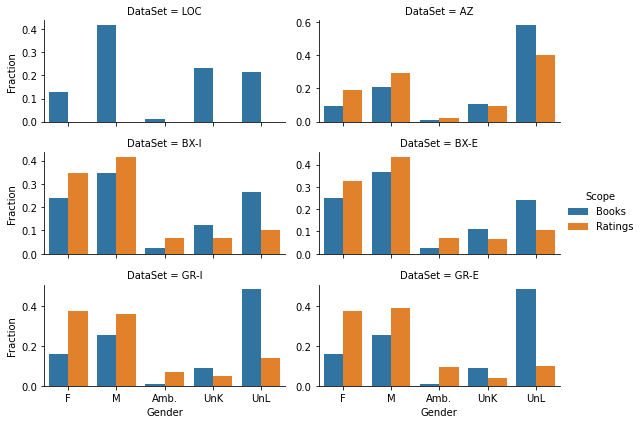

In [42]:
sns.catplot(x='Gender', y='Fraction', col='DataSet', col_wrap=2, hue='Scope',
            data=gs_tall.reset_index(),
            kind='bar', sharey=False, height=2, aspect=2)

Manual plotting logic for the paper:

D:\Research\book-rec-fairness\bookgender\nbutils.py:39: UserWarning: file has suffix, ignoring
C:\Users\michaelekstrand\Anaconda3\envs\bookfair\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 7 x 4.5 in image.
C:\Users\michaelekstrand\Anaconda3\envs\bookfair\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: figures\DataSummary\link-stats.pdf
C:\Users\michaelekstrand\Anaconda3\envs\bookfair\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 7 x 4.5 in image.
C:\Users\michaelekstrand\Anaconda3\envs\bookfair\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: figures\DataSummary\link-stats.png


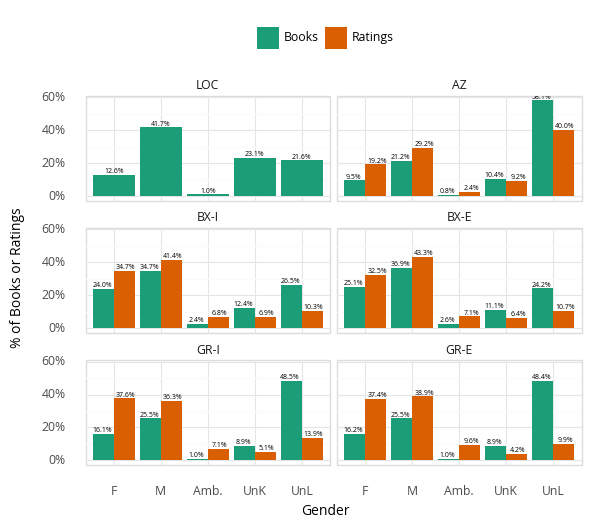

<ggplot: (-9223371939947189592)>

In [43]:
make_plot(gs_tall, p.aes('Gender', 'Fraction', fill='Scope'),
    p.geom_bar(stat='identity', position='dodge'),
    p.geom_text(p.aes(label='Fraction*100'), format_string='{:.1f}%', size=5, 
                position=p.position_dodge(width=1), va='bottom'),
    p.facet_wrap('~DataSet', ncol=2),
    p.scale_fill_brewer('qual', 'Dark2'),
    p.scale_y_continuous(labels=lbl_pct),
    p.ylab('% of Books or Ratings'),
    legend_position='top', legend_title=p.element_blank(),
    file='link-stats.pdf', width=7, height=4.5)

Known-gender books:

In [44]:
k_bc = book_counts[['male', 'female']]
k_bf = k_bc.divide(k_bc.sum(axis=1), axis=0)
k_bf = k_bf.loc[['LOC', 'AZ', 'BX-I', 'GR-I']]
k_bf

gender_status,male,female
DataSet,,
LOC,0.767701,0.232299
AZ,0.690375,0.309625
BX-I,0.590983,0.409017
GR-I,0.612701,0.387299


In [45]:
print((k_bf * 100).to_latex(float_format='%.1f%%'))

\begin{tabular}{lrr}
\toprule
gender\_status &  male &  female \\
DataSet &       &         \\
\midrule
LOC     & 76.8\% &   23.2\% \\
AZ      & 69.0\% &   31.0\% \\
BX-I    & 59.1\% &   40.9\% \\
GR-I    & 61.3\% &   38.7\% \\
\bottomrule
\end{tabular}



In [46]:
k_bf.columns = k_bf.columns.astype('str')
k_bft = k_bf.reset_index().melt(id_vars='DataSet', var_name='gender')
k_bft['gender'] = k_bft.gender.astype('category').cat.reorder_categories(['male', 'female'])
k_bft['DataSet'] = k_bft.DataSet.astype('category').cat.reorder_categories(['LOC', 'AZ', 'BX-I', 'GR-I'])

D:\Research\book-rec-fairness\bookgender\nbutils.py:39: UserWarning: file has suffix, ignoring
C:\Users\michaelekstrand\Anaconda3\envs\bookfair\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 4 x 2.5 in image.
C:\Users\michaelekstrand\Anaconda3\envs\bookfair\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: figures\DataSummary\frac-known-books.pdf
C:\Users\michaelekstrand\Anaconda3\envs\bookfair\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 4 x 2.5 in image.
C:\Users\michaelekstrand\Anaconda3\envs\bookfair\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: figures\DataSummary\frac-known-books.png


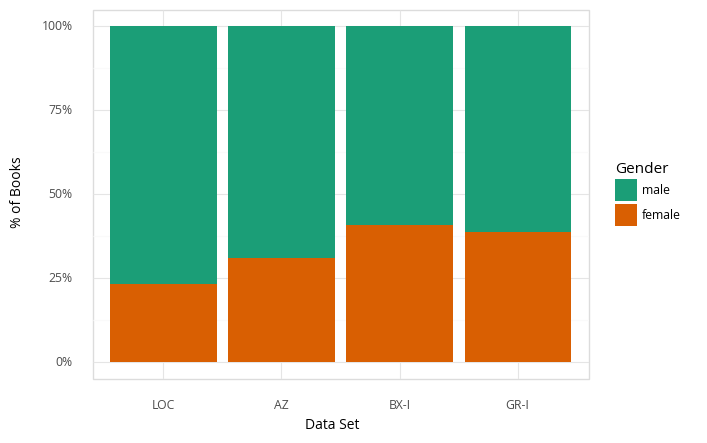

<ggplot: (-9223371939936570724)>

In [47]:
make_plot(k_bft, p.aes('DataSet', 'value', fill='gender'),
          p.geom_bar(stat='identity'),
          p.scale_fill_brewer('qual', 'Dark2'),
          p.labs(x='Data Set', y='% of Books', fill='Gender'),
          p.scale_y_continuous(labels=lbl_pct),
          file='frac-known-books.pdf', width=4, height=2.5)

And do that again for ratings.

In [48]:
rate_counts = full_stats['Ratings'].unstack()
k_rc = rate_counts[['male', 'female']]
k_rf = k_rc.divide(k_rc.sum(axis=1), axis=0)
k_rf = k_rf.loc[datasets]
k_rf

gender_status,male,female
DataSet,,
AZ,0.603181,0.396819
BX-E,0.571364,0.428636
BX-I,0.544148,0.455852
GR-E,0.509770,0.490230
GR-I,0.490939,0.509061


In [49]:
all_cts = full_stats.reorder_levels([1,0]).loc[['male', 'female']].reorder_levels([1,0]).unstack()
all_cts.sort_index(axis=1, inplace=True)
print(all_cts.divide(all_cts.sum(axis=1, level=0), axis=0, level=0).to_latex(float_format=lambda f: '{:.1f}%'.format(f*100)))

\begin{tabular}{lrrrr}
\toprule
{} & \multicolumn{2}{l}{Books} & \multicolumn{2}{l}{Ratings} \\
gender\_status & female &  male &  female &  male \\
DataSet &        &       &         &       \\
\midrule
LOC     &  23.2\% & 76.8\% &   23.2\% & 76.8\% \\
AZ      &  31.0\% & 69.0\% &   39.7\% & 60.3\% \\
BX-E    &  40.5\% & 59.5\% &   42.9\% & 57.1\% \\
BX-I    &  40.9\% & 59.1\% &   45.6\% & 54.4\% \\
GR-E    &  38.8\% & 61.2\% &   49.0\% & 51.0\% \\
GR-I    &  38.7\% & 61.3\% &   50.9\% & 49.1\% \\
\bottomrule
\end{tabular}



In [50]:
k_rf.columns = k_rf.columns.astype('str')
k_rft = k_rf.reset_index().melt(id_vars='DataSet', var_name='gender')
k_rft['gender'] = k_rft.gender.astype('category').cat.reorder_categories(['male', 'female'])
k_rft['DataSet'] = k_rft.DataSet.astype('category').cat.reorder_categories(datasets)

D:\Research\book-rec-fairness\bookgender\nbutils.py:39: UserWarning: file has suffix, ignoring
C:\Users\michaelekstrand\Anaconda3\envs\bookfair\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 4 x 2.5 in image.
C:\Users\michaelekstrand\Anaconda3\envs\bookfair\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: figures\DataSummary\frac-known-rates.pdf
C:\Users\michaelekstrand\Anaconda3\envs\bookfair\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 4 x 2.5 in image.
C:\Users\michaelekstrand\Anaconda3\envs\bookfair\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: figures\DataSummary\frac-known-rates.png


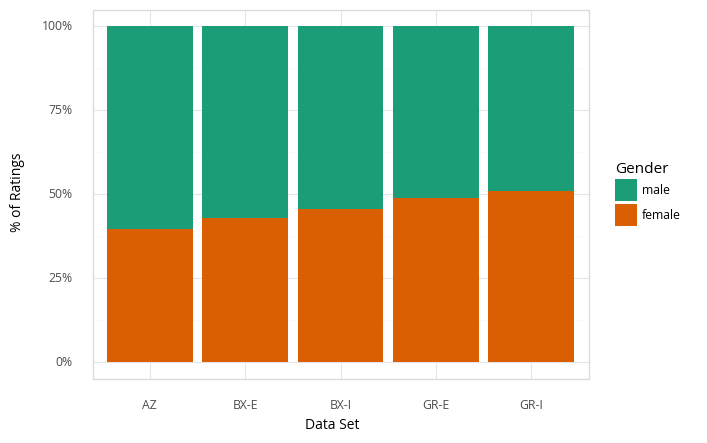

<ggplot: (-9223371939882777772)>

In [51]:
make_plot(k_rft, p.aes('DataSet', 'value', fill='gender'),
          p.geom_bar(stat='identity'),
          p.scale_fill_brewer('qual', 'Dark2'),
          p.scale_y_continuous(labels=lbl_pct),
          p.labs(x='Data Set', y='% of Ratings', fill='Gender'),
          file='frac-known-rates.pdf', width=4, height=2.5)

## Popularity and Gender Distributions

We now want to look at popularity and assorted distributions.

We will start by computing item statistics.

In [52]:
def _ds_stats(ds, df):
    eprint('summarizing ', ds)
    stats = df.groupby('item').user.count().reset_index(name='nratings')
    stats = stats.join(book_gender, on='item')
    stats['PopRank'] = stats['nratings'].rank()
    stats['PopRank'] = stats['PopRank'] / stats['PopRank'].max()
    stats['PopQ'] = (stats['PopRank'] * 100).round().astype('i4')
    stats['Set'] = ds
    return stats
item_stats = pd.concat(_ds_stats(ds, df) for (ds, df) in ratings.items() if not ds.endswith('-E'))
item_stats['Set'] = item_stats['Set'].astype('category')
item_stats.head()

summarizing  AZ
summarizing  BX-I
summarizing  GR-I


,item,nratings,gender_status,gender,PopRank,PopQ,Set
0,0,4,male,male,0.652857,65,AZ
1,2,65,male,male,0.977629,98,AZ
2,5,89,no-loc-author,unlinked,0.984913,98,AZ
3,8,19,male,male,0.911341,91,AZ
4,11,32,male,male,0.948883,95,AZ


Compute rating count histograms:

C:\Users\michaelekstrand\Anaconda3\envs\bookfair\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log10


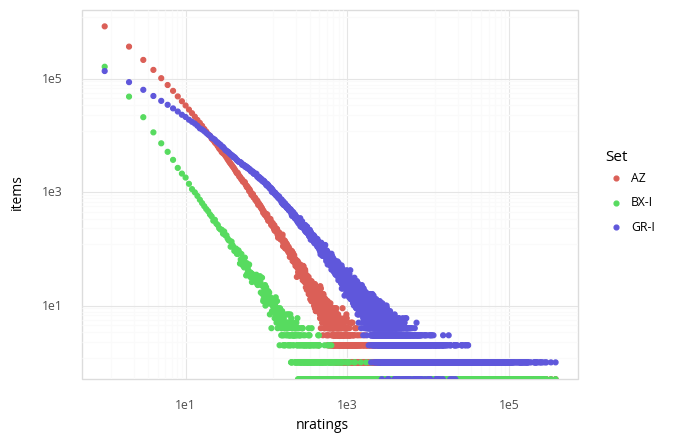

<ggplot: (-9223371939881977216)>

In [53]:
nr_hist = item_stats.groupby(['Set', 'nratings'])['item'].count().reset_index(name='items')
make_plot(nr_hist, p.aes(x='nratings', y='items', color='Set'),
          p.geom_point(),
          p.scale_x_log10(),
          p.scale_y_log10())

Let's look at rating count per book by gender resolution:

In [54]:
rate_rates = item_stats.groupby(['Set', 'gender'])['nratings'].agg(['mean', 'median'])
rr_stat = rate_rates.unstack().swaplevel(axis=1).loc[:, ['male', 'female']].sort_index(axis=1)
print(rr_stat.to_latex(float_format='%.2f'))

\begin{tabular}{lrrrr}
\toprule
gender & \multicolumn{2}{l}{female} & \multicolumn{2}{l}{male} \\
{} &   mean & median &   mean & median \\
Set  &        &        &        &        \\
\midrule
AZ   &  20.01 &      4 &  13.64 &      3 \\
BX-I &   5.84 &      2 &   4.82 &      1 \\
GR-I & 402.35 &     34 & 245.28 &     20 \\
\bottomrule
\end{tabular}



Now compute gender histograms by percentile so we can stack:

In [55]:
pop_g = item_stats.groupby(['Set', 'PopQ', 'gender'], observed=True)['item'].count().unstack()
pop_g.fillna(0, inplace=True)
pop_g = pop_g.divide(pop_g.sum(axis=1), axis=0)
pop_g.sort_index(inplace=True)
pop_g.head()

gender        male  unlinked    female   unknown  ambiguous
Set PopQ                                                   
AZ  18    0.174433  0.667347  0.067153  0.085216   0.005852
    45    0.207661  0.593931  0.085052  0.106450   0.006905
    57    0.219571  0.567501  0.091894  0.114128   0.006906
    65    0.225784  0.554707  0.095220  0.116672   0.007617
    71    0.229021  0.542932  0.100422  0.120130   0.007495

Propagate to percentile 0, so we can plot the whole width:

In [56]:
for ds in pop_g.index.levels[0].categories:
    dspg = pop_g.loc[ds, :]
    pop_g.loc[(ds, 0), :] = dspg.iloc[0, :]
pop_g.sort_index(inplace=True)

Stack for plotting:

In [57]:
pop_g = pop_g.stack().reset_index(name='items')
pop_g.head()

,Set,PopQ,gender,items
0,AZ,0,male,0.174433
1,AZ,0,unlinked,0.667347
2,AZ,0,female,0.067153
3,AZ,0,unknown,0.085216
4,AZ,0,ambiguous,0.005852


In [58]:
pop_g['gender'].cat.reorder_categories([
    'male', 'female', 'ambiguous',
    'unknown', 'unlinked'
], inplace=True)

And make an area plot.

C:\Users\michaelekstrand\Anaconda3\envs\bookfair\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 8 x 5 in image.
C:\Users\michaelekstrand\Anaconda3\envs\bookfair\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: figures\DataSummary\gender-by-pop.pdf
C:\Users\michaelekstrand\Anaconda3\envs\bookfair\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 8 x 5 in image.
C:\Users\michaelekstrand\Anaconda3\envs\bookfair\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: figures\DataSummary\gender-by-pop.png


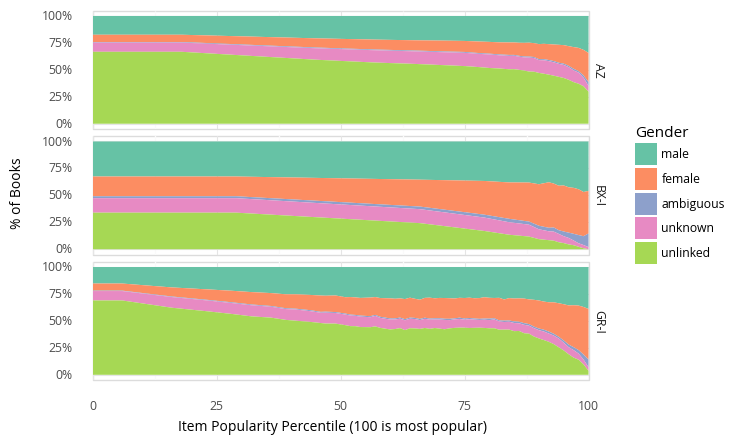

<ggplot: (-9223371939882010988)>

In [59]:
make_plot(pop_g, p.aes(x='PopQ', y='items', fill='gender'),
          p.geom_area(),
          p.scale_fill_brewer('qual', 'Set2'),
          p.scale_y_continuous(labels=lbl_pct),
          p.scale_x_continuous(expand=(0,0)),
          p.facet_grid('Set ~'),
          p.labs(x='Item Popularity Percentile (100 is most popular)',
                 y='% of Books',
                 fill='Gender'),
          file='gender-by-pop', width=8, height=5)